In [2]:
from typing import List, Union
import pandas as pd
import numpy as np
import ast

from rdkit import Chem

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm import tqdm


from joblib import Parallel, delayed


In [3]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is correctly set up
print(torch.cuda.get_device_name(0))  # Should return the name of your GPU

True
NVIDIA GeForce RTX 2080 SUPER


In [4]:
class FeaturizationParameters:
    def __init__(self):
        self.max_atomic_num = 100
        self.atom_features = {
            'atomic_num': list(range(self.max_atomic_num)),
            'degree': [0, 1, 2, 3, 4, 5],
            'formal_charge': [-1, -2, 1, 2, 0],
            'chiral_tag': [0, 1, 2, 3],
            'num_Hs': [0, 1, 2, 3, 4],
            'hybridization': [
                Chem.rdchem.HybridizationType.SP,
                Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3,
                Chem.rdchem.HybridizationType.SP3D,
                Chem.rdchem.HybridizationType.SP3D2
            ],
        }
        self.atom_fdim = sum(len(choices) + 1 for choices in self.atom_features.values()) + 2
        # skipatom
        # посмотреть какие атомные фичи есть

def onek_encoding_unk(value, choices):
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1
    return encoding

def atom_features(atom, params):
    features = onek_encoding_unk(atom.GetAtomicNum() - 1, params.atom_features['atomic_num']) + \
               onek_encoding_unk(atom.GetTotalDegree(), params.atom_features['degree']) + \
               onek_encoding_unk(atom.GetFormalCharge(), params.atom_features['formal_charge']) + \
               onek_encoding_unk(int(atom.GetChiralTag()), params.atom_features['chiral_tag']) + \
               onek_encoding_unk(int(atom.GetTotalNumHs()), params.atom_features['num_Hs']) + \
               onek_encoding_unk(int(atom.GetHybridization()), params.atom_features['hybridization']) + \
               [1 if atom.GetIsAromatic() else 0] + \
               [atom.GetMass() * 0.01]  # scaled to about the same range as other features
    return features

PARAMS = {
    'BOND_FDIM': 10
}

def bond_features(bond: Chem.rdchem.Bond) -> List[Union[bool, int, float]]:
    if bond is None:
        fbond = [1] + [0] * (PARAMS['BOND_FDIM'] - 1)
    else:
        bt = bond.GetBondType()
        fbond = [
            0,  # bond is not None
            bt == Chem.rdchem.BondType.SINGLE,
            bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE,
            bt == Chem.rdchem.BondType.AROMATIC,
            bond.GetIsConjugated() if bt is not None else 0,
            bond.IsInRing() if bt is not None else 0
        ]
        fbond += onek_encoding_unk(int(bond.GetStereo()), list(range(6)))
    return fbond


class MoleculeData:
    def __init__(self, smiles, target, addHs=True):
        self.smiles = smiles
        self.target = torch.tensor(target, dtype=torch.float)
        self.mol = Chem.MolFromSmiles(smiles)
        if addHs:
            self.mol = Chem.AddHs(self.mol)
        self.params = FeaturizationParameters()
        self.edge_index, self.edge_attr = self.construct_graph()

    def construct_graph(self):
        edge_index = []
        edge_attr = []
        for bond in self.mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            edge_index.extend([[start, end], [end, start]])
            edge_attr.extend([bond_features(bond), bond_features(bond)])  # Добавляем признаки для обеих направлений связи
        return torch.tensor(edge_index).t().contiguous(), torch.tensor(edge_attr, dtype=torch.float)

    def generate_atom_features(self):
        features = []
        for atom in self.mol.GetAtoms():
            features.append(atom_features(atom, self.params))
        return torch.tensor(features, dtype=torch.float)

class MoleculeDataset(Dataset):
    def __init__(self, dataframe, smiles_column='smiles', target_column='target', addHs=True, n_jobs=-1):
        super(MoleculeDataset, self).__init__()
        self.data_list = Parallel(n_jobs=n_jobs)(
            delayed(lambda row: MoleculeData(row[smiles_column], row[target_column], addHs))(
                row) for _, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]))

    def len(self): 
        return len(self.data_list)

    def get(self, idx):
        molecule_data = self.data_list[idx]
        x = molecule_data.generate_atom_features()
        edge_index = molecule_data.edge_index
        edge_attr = molecule_data.edge_attr
        y = molecule_data.target
        
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        data.smiles = molecule_data.smiles
        
        return data


In [5]:
molecule_dataset = torch.load('../data/QM_137k.pt')
print(molecule_dataset)
for i in range(2):
    print(molecule_dataset[i])

MoleculeDataset(100)
Data(x=[31, 133], edge_index=[2, 64], edge_attr=[64, 14], y=[31], smiles='CNC(=S)N/N=C/c1c(O)ccc2ccccc12')
Data(x=[36, 133], edge_index=[2, 76], edge_attr=[76, 14], y=[36], smiles='O=C(NCCn1cccc1)c1cccc2ccccc12')


In [6]:
indices = list(range(len(molecule_dataset)))
train_val_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.125, random_state=42)  # 0.125 * 0.8 = 0.1

train_dataset = [molecule_dataset[i] for i in tqdm(train_indices, desc="Creating Train Dataset")]
val_dataset = [molecule_dataset[i] for i in tqdm(val_indices, desc="Creating Validation Dataset")]
test_dataset = [molecule_dataset[i] for i in tqdm(test_indices, desc="Creating Test Dataset")]

batch_size = 128

dataset = DataLoader(molecule_dataset, batch_size=batch_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Creating Test Dataset: 100%|██████████| 20/20 [00:00<00:00, 822.90it/s]


In [7]:
for batch in train_loader:
    print(batch)

DataBatch(x=[2246, 133], edge_index=[2, 4586], edge_attr=[4586, 14], y=[2246], smiles=[70], batch=[2246], ptr=[71])


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


in_features = 133                # Количество входных признаков для каждого узла
out_features =  1                # Количество выходных признаков
num_epochs = 100                 # Количество эпох обучения 1000
learning_rate = 0.005            # Скорость обучения
weight_decay = 5e-4              # Вес распада для регуляризации
warmup_epochs = 2                
initial_lr = learning_rate  
patience = 10                    # 100
best_val_loss = float('inf')
epochs_no_improve = 0

hidden_features = 64             # Количество скрытых признаков
num_heads = 1                    # Количество "голов" в механизме внимания
dropout_rate = 0.1                 # Процент дропаута

train_losses = []
val_losses = []

# Определение модели
class GATv2Model(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_heads, dropout_rate):
        super(GATv2Model, self).__init__()
        #MPN простой
        self.conv1 = GATv2Conv(in_channels=in_features, out_channels=hidden_features,
                               heads=num_heads, dropout=dropout_rate, concat=True)
        self.bn1 = torch.nn.BatchNorm1d(hidden_features * num_heads)
        self.conv2 = GATv2Conv(in_channels=hidden_features * num_heads, out_channels=out_features, 
                               heads=1, concat=False, dropout=dropout_rate)
        #FFN слой 
        # убрать дропаут с выходного
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(self.bn1(x)) # разные hyper
        x = F.dropout(x, training=self.training, p=dropout_rate)
        x = self.conv2(x, edge_index)
        return x.squeeze()

model = GATv2Model(
        in_features=in_features,
        hidden_features=hidden_features,
        out_features=out_features,
        num_heads=num_heads,
        dropout_rate=dropout_rate
    )

model.to(device)
print(f"Model:\n{model}")

# Определение функции потерь и оптимизатора
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) #hyper lbfgs

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)   reducelronplate oneciklelr цикл



print('Start Train')
model.train()

for epoch in range(num_epochs):
    # Разогревочные эпохи ????
    if epoch < warmup_epochs:
        lr = initial_lr * (epoch + 1) / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    else:
        lr = initial_lr
    
    # Обучение
    model.train()
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = loss_func(out, batch.y)
        loss.backward()
        optimizer.step()
        
    train_losses.append(loss.item())
    
    # Валидация
    model.eval()
    val_loss_accum = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch.to(device)
            val_out = model(batch.x, batch.edge_index)
            val_loss = loss_func(val_out, batch.y)
            val_loss_accum += val_loss.item()
        
    avg_val_loss = val_loss_accum / len(val_loader)
    val_losses.append(avg_val_loss) 
    print(f'Epoch {epoch+1} | LR: {lr:.4f} | Train Loss: {loss.item():.4f} | Val Loss: {avg_val_loss:.4f}')
    
    #scheduler.step()
    
    # Ранняя остановка
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping triggered. No improvement in {patience} epochs.')
            break


Device: cuda
Model:
GATv2Model(
  (conv1): GATv2Conv(133, 64, heads=1)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATv2Conv(64, 1, heads=1)
)
Start Train
Epoch 1 | LR: 0.0025 | Train Loss: 0.6146 | Val Loss: 0.1281
Epoch 2 | LR: 0.0050 | Train Loss: 0.3460 | Val Loss: 0.1517
Epoch 3 | LR: 0.0050 | Train Loss: 0.2128 | Val Loss: 0.1784
Epoch 4 | LR: 0.0050 | Train Loss: 0.2422 | Val Loss: 0.1846
Epoch 5 | LR: 0.0050 | Train Loss: 0.2102 | Val Loss: 0.1783
Epoch 6 | LR: 0.0050 | Train Loss: 0.2066 | Val Loss: 0.1547
Epoch 7 | LR: 0.0050 | Train Loss: 0.2098 | Val Loss: 0.1231
Epoch 8 | LR: 0.0050 | Train Loss: 0.1898 | Val Loss: 0.0956
Epoch 9 | LR: 0.0050 | Train Loss: 0.1683 | Val Loss: 0.0801
Epoch 10 | LR: 0.0050 | Train Loss: 0.1260 | Val Loss: 0.0744
Epoch 11 | LR: 0.0050 | Train Loss: 0.1148 | Val Loss: 0.0728
Epoch 12 | LR: 0.0050 | Train Loss: 0.1218 | Val Loss: 0.0755
Epoch 13 | LR: 0.0050 | Train Loss: 0.1247 | Val Loss:

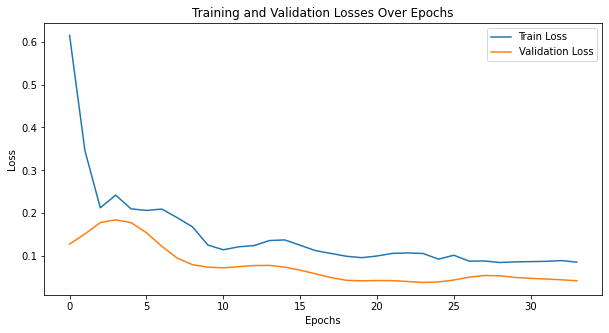

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.show()

In [10]:
data = []
all_predictions = []
all_true_values = []

model.eval()
with torch.no_grad():
    for batch in test_loader: 
        batch.to(device)
        preds = model(batch.x, batch.edge_index)

        preds_np = preds.cpu().numpy()
        true_values_np = batch.y.cpu().numpy()
        all_predictions.extend(preds_np)  
        all_true_values.extend(true_values_np)  

        start_idx = 0
        for i, num_atoms in enumerate(batch.ptr[:-1]): 
            end_idx = batch.ptr[i+1].item()
            molecule_preds = preds_np[start_idx:end_idx]
            molecule_true_values = true_values_np[start_idx:end_idx]

            data.append({
                'smiles': batch.smiles[i],
                'predictions': molecule_preds,
                'true_values': molecule_true_values
            })

            start_idx = end_idx  



df_results = pd.DataFrame(data)


In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

all_predictions = []
all_true_values = []

for index, row in df_results.iterrows():
    all_predictions.extend(row['predictions'])
    all_true_values.extend(row['true_values'])

all_predictions_array = np.array(all_predictions)
all_true_values_array = np.array(all_true_values)

rmse = np.sqrt(mean_squared_error(all_true_values_array, all_predictions_array))
mse = mean_squared_error(all_true_values_array, all_predictions_array)
r2 = r2_score(all_true_values_array, all_predictions_array)
mae = mean_absolute_error(all_true_values_array, all_predictions_array)

print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')
print(f'R²: {r2:.4f}')
print(f'MAE: {mae:.4f}')


RMSE: 0.2079
MSE: 0.0432
R²: -0.0520
MAE: 0.1528


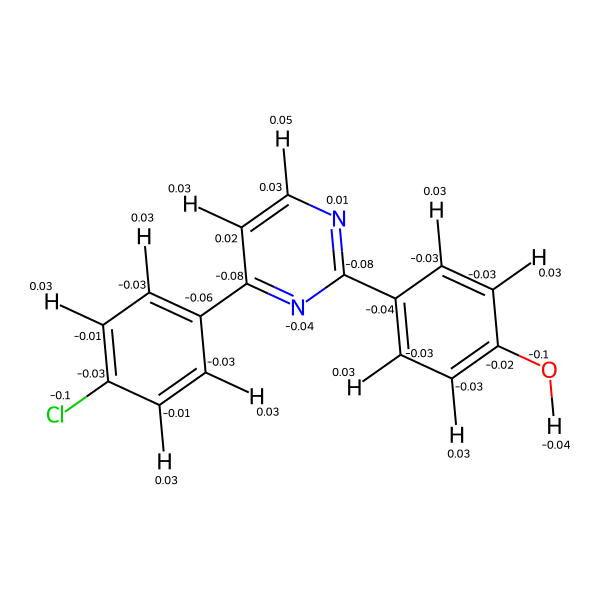

In [12]:
from rdkit import Chem
from rdkit.Chem import Draw


smiles = df_results.iloc[0]['smiles']
predictions = np.round(df_results.iloc[0]['predictions'], 2)


mol = Chem.AddHs(Chem.MolFromSmiles(smiles))

for atom, pred in zip(mol.GetAtoms(), predictions):
    atom.SetProp('atomNote', str(pred))


img = Draw.MolToImage(mol, size=(600, 600), kekulize=True)

# Показать изображение
img.show()
